In [ ]:
!pip install easyocr

frame:225, Detected text: 371도2250
frame:225,Carcolor: white
frame:240, Detected text: 371도2250
frame:240,Carcolor: white
frame:255, Detected text: 371도2250
frame:255,Carcolor: white


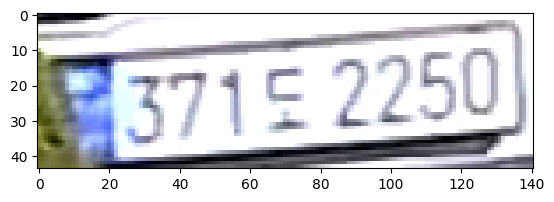

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import easyocr
import warnings
import re
warnings.filterwarnings("ignore")

# YOLO 모델 로드
plate_model = YOLO('carplate/train/weights/best.pt')
color_model = YOLO('colordetection2/train/weights/best.pt')

# EasyOCR 리더 객체 생성
reader = easyocr.Reader(['ko'])

# 동영상 파일 경로
video_path = "test1.avi"

# 동영상 캡처 객체 생성
cap = cv2.VideoCapture(video_path)

# 1초 간격으로 프레임 처리
frame_interval = 1  # 1초 간격
frame_count = 0
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))  # 프레임 레이트 가져오기

# 출력할 텍스트 패턴 정규표현식 번호판이 앞에 2~3개가 숫자고 그 다음에 한글, 그다음에 숫자 4자리일 때만 출력
pattern = r'^\d{2,3}[가-힣]+\d{4}$'

while True:
    ret, img = cap.read()
    if not ret:
        break
    
    flag = False

    if frame_count % (frame_rate * frame_interval) == 0:
        # 번호판 detection
        plate_result = plate_model.predict(source=img, imgsz=640, verbose=False)
        # 색깔 detection
        color_result = color_model.predict(source=img, imgsz=640, conf=0.6, verbose=False)

        # 예측된 바운딩 박스를 순회
        for bbox in plate_result[0].boxes:
            # 바운딩 박스 좌표 추출
            x1, y1, x2, y2 = map(int, bbox.xyxy[0])
            # 바운딩 박스 영역 크롭
            cropped_img = img[y1:y2, x1:x2]
             # 바운딩 박스가 화면 중앙 근처인지 판단
            img_height, img_width, _ = img.shape
            center_x = img_width // 2
            bbox_center_x = (x1 + x2) // 2
            # 바운딩 박스의 가로 위치가 중간 영역인지 판단
            img_width = img.shape[1]
            bbox_center_x = (x1 + x2) // 2
            # 차량 넘버 플레이트가 화면 중앙 근처에 왔으면서, 색상 검출 bbox 가 있을때
            if img_width // 3 <= bbox_center_x <= img_width * 3 // 3 and len(color_result[0].boxes.cls) > 0:
                # EasyOCR을 사용하여 텍스트 인식
                ocr_result = reader.readtext(cropped_img)
                if len(ocr_result) > 0:
                    # 인식된 텍스트 출력
                    ocr_bbox, text, prob = ocr_result[0]
                    text = re.sub('[^가-힣0-9]', '', text)
                    # 번호판이 앞에 2~3개가 숫자고 그 다음에 한글, 그다음에 숫자 4자리일 때만 출력
                    if re.match(pattern, text):
                        print(f"frame:{frame_count}, Detected text: {text}")
                        flag = True

                    # 크롭된 이미지와 OCR 결과를 시각화 표시
            # OCR 사진 확인용
            plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            # 프레임 확인용
            #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            #plt.title(f"Detected text: {text}")
            #plt.show()
        if len(color_result[0].boxes.cls) > 0 and flag == True:
            # 잡힌 클래스 출력
            class_id = int(color_result[0].boxes.cls)
            confidence = color_result[0].boxes.conf
            class_name = color_model.names[class_id]
            print(f"frame:{frame_count},Carcolor:", color_result[0].names[class_id])

    frame_count += 1

In [ ]:
plate_result = plate_model.predict(source=img, imgsz=640, verbose=False)